# Crayon Data - Assignment

Objective: Analyzing Customer Spending Behavior

Algorithms Used:
    
1. K-Means Clustering
2. Apriori Algorithm

In [877]:
# import libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import calendar
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

%matplotlib inline
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

# Data Import/Manipulate

In [941]:
df=pd.read_csv('data.csv')
df.drop(['cleaned_merchant_name.1','country','finalmerchid','MCC'], axis=1, inplace=True)

Data Dimensions

In [942]:
df.shape

(1048575, 5)

Data Schema

In [943]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
customerId               1048575 non-null object
local_amount             1048575 non-null int64
cleaned_merchant_name    1048575 non-null object
city                     1048575 non-null object
txn_date                 1048575 non-null object
dtypes: int64(1), object(4)
memory usage: 40.0+ MB


Data Overview

In [944]:
df.head()

,customerId,local_amount,cleaned_merchant_name,city,txn_date
0,B01A04153D,23,Jumbo Seafood Riverside,Singapore,10/1/2016
1,B01A02172D,33,Jumbo Seafood Riverside,Singapore,20/1/2016
2,B01A06504D,25,Jumbo Seafood Riverside,Singapore,20/1/2016
3,B02A01824D,108,Jumbo Seafood Riverside,Singapore,15/1/2016
4,B02A05662D,9,Jumbo Seafood Riverside,Singapore,13/1/2016


# Global Functions

In [945]:
def get_day_of_week(val):
    return datetime.strptime(val, '%d/%m/%Y').weekday()

def get_month(val):
    return datetime.strptime(val, '%d/%m/%Y').month

def get_year(val):
    return datetime.strptime(val, '%d/%m/%Y').year

def get_day(val):
    return datetime.strptime(val, '%d/%m/%Y').day

# EDA

Total Customers

In [946]:
df['customerId'].nunique()

49970

Total Merchants

In [947]:
df['cleaned_merchant_name'].nunique()

15750

# Interactive Customer Summary

Click on "Customer ID" or "Merchant Name" to Filter Data

In [1]:
%%html

<div class='tableauPlaceholder' id='viz1537023503080' style='position: relative'><noscript><a href='#'><img alt='Dashboard 1 ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Cr&#47;Crayon&#47;Dashboard1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='Crayon&#47;Dashboard1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Cr&#47;Crayon&#47;Dashboard1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1537023503080');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

Get Merchants with maximum transactions

In [948]:
merchant_count=pd.DataFrame(df.groupby(['cleaned_merchant_name']).count())

merchant_count=merchant_count.sort_values('customerId', ascending=False)
merchant_count.reset_index(inplace=True)

List of top 20 Merchants By Count of Transactions

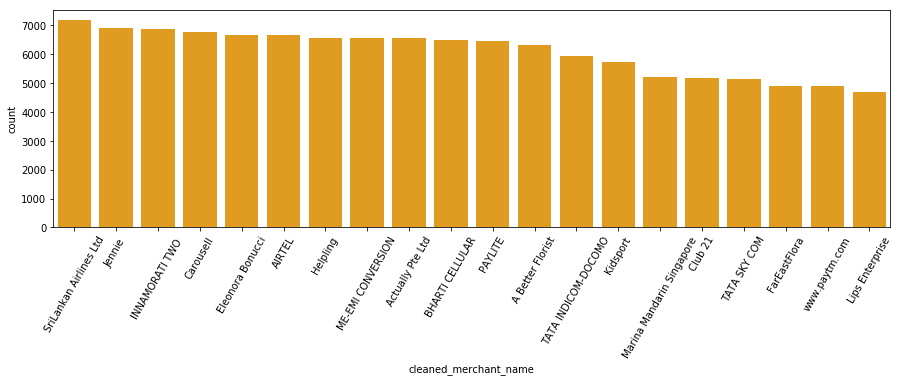

In [949]:
merchant_count.drop(['local_amount','city','txn_date'], axis=1, inplace=True)
merchant_count.columns=['cleaned_merchant_name','count']
merchant_count_plot=merchant_count.iloc[:20]
plt.figure(figsize=(15,4))
plt.xticks(rotation=60)
sns.barplot(merchant_count_plot['cleaned_merchant_name'], merchant_count_plot['count'], color='orange')

Total Merchants with more than 800 Transactions

In [950]:
merchant_count=merchant_count[merchant_count['count']>=800]
merchant_count.shape

(151, 2)

Let's filter out merchants that have transactions less than 800 & see how many customers can we preserve

In [951]:
merchant_count['keep']=1

df=pd.merge(df, merchant_count, on='cleaned_merchant_name')
df=df[df.keep==1]

df['customerId'].nunique()

46394

We were able to preserve more than 90% of the customers

In [952]:
df.drop(['count','keep'], axis=1, inplace=True)

In [955]:
df.columns=['customerId', 'local_amount', 'merchant', 'city', 'txn_date']

Data Overview

In [956]:
df.head()

,customerId,local_amount,merchant,city,txn_date
0,B01A08255D,24,Restaurant Absinthe,Singapore,18/1/2016
1,B01A00107D,65,Restaurant Absinthe,Singapore,28/1/2016
2,B01A01678D,8,Restaurant Absinthe,Singapore,21/1/2016
3,B01A00610D,12,Restaurant Absinthe,Singapore,5/1/2016
4,B01A06536D,28,Restaurant Absinthe,Singapore,1/1/2016


Break transaction date into month, week of day, and year

In [957]:
df['weekday']=df['txn_date'].apply(get_day_of_week)
df['month']=df['txn_date'].apply(get_month)
df['year']=df['txn_date'].apply(get_year)
df['day']=df['txn_date'].apply(get_day)

df.drop(['txn_date'], axis=1, inplace=True)
df.head()

,customerId,local_amount,merchant,city,weekday,month,year,day
0,B01A08255D,24,Restaurant Absinthe,Singapore,0,1,2016,18
1,B01A00107D,65,Restaurant Absinthe,Singapore,3,1,2016,28
2,B01A01678D,8,Restaurant Absinthe,Singapore,3,1,2016,21
3,B01A00610D,12,Restaurant Absinthe,Singapore,1,1,2016,5
4,B01A06536D,28,Restaurant Absinthe,Singapore,4,1,2016,1


# Finding Patterns using K-Means

Objective: Using K-means we'll look into our data from the "Week of Day" level. From Monday to Sunday we'll pick appropriate number of clusters for each day and see how spending is affected by day.

For each cluster in a day, we'll list down the top merchants where people spend the most and the least in terms of "local_amount"

How to use the Insights:
Let's say we find out that on Friday's one of the cluster "Cluster No. 3" shows the highest average spend of local amount. On observing the cluster, we find out that "Restaurant Absinthe" shares tha maximum amount of transaction share for that day. Now, we'd know where do people spend most of their money on a Friday.

In [850]:
wd=0

df=df[df['weekday']==0]
df.shape

(50117, 8)

This the amount of data we have for this particular day

# Basic Cleaning

In [959]:
df['city']=df['city'].apply(lambda x:1 if x=='Singapore' else 0)

df_1=pd.get_dummies(df[['merchant']])

df.drop(['customerId','merchant','city'], inplace=True, axis=1)
df=pd.concat([df,df_1], axis=1)

Change the structure of data to "Merchant" level

In [960]:
df.head()

,local_amount,weekday,month,year,day,merchant_A B Piyasena Jewellers,merchant_A Better Florist,merchant_AIRCEL,merchant_AIRTEL,merchant_Actually Pte Ltd,merchant_Alain Figaret (Singapore) Pte Ltd,merchant_Alef Motif,merchant_AliExpress,merchant_Alibaba,merchant_All Nippon Airways Co Ltd,merchant_American Airlines,merchant_Amore-Venti,merchant_Archz Boutique,merchant_BALANCE CONVERSION - 001/006,merchant_BALANCE CONVERSION - 003/006,merchant_BALANCE CONVERSION - 005/006,merchant_BALANCE CONVERSION - 006/006,merchant_BANGALORE ELECTRICITY,merchant_BESCOM PAYMENT,merchant_BHARATI TELEMEDIA,merchant_BHARTI CELLULAR,merchant_BHARTI INFOTEL,merchant_BeautyFresh,merchant_Bee Hoe Fashions,merchant_Benjamin Barker,merchant_Billet-Doux,merchant_Bistecca Tuscan Steakhouse,merchant_Bods & Leggs,merchant_ButtonNStitch,merchant_Cafebond,merchant_Capella Singapore,merchant_Carousell,merchant_Catalogue,merchant_Cathay Pacific Airways Ltd,merchant_Chia Huay Cheok,merchant_China Airlines Ltd,merchant_Chock Full of Beans,merchant_Cilla Creative Pursuit,merchant_Club 21,merchant_Club21,merchant_Cocomi Online Store,merchant_D2H,merchant_DAIL-AN-EMI,merchant_Denizen,merchant_Eleonora Bonucci,merchant_F-B Fashion & Beauty,merchant_FREECHARGE PU,merchant_FREECHARGE.IN-PAYU,merchant_FarEastFlora,merchant_Feng Shui Inn,merchant_Get Set Go,merchant_HBX,merchant_Hai Tien Lo,merchant_Happyfresh,merchant_Helpling,merchant_Her Velvet Vase,merchant_Hombre Cantina,merchant_Honestbee,merchant_IDEA,merchant_IKYU,merchant_INNAMORATI TWO,merchant_JURLIQUE,merchant_Jade,merchant_Jennie,merchant_Keyaki,merchant_Kidsport,merchant_Kidzloft,merchant_Kuvo,merchant_Kwang Sia Fashion Company,merchant_Kwang Sia Pte Ltd,merchant_La-Vie Fashion & Bridal,merchant_Lashino Trading,merchant_Lazada,merchant_Lemon Dot Fashion Pte Ltd,merchant_Levi�s,merchant_Lian Qi Fashion,merchant_Lian Seng Fashion & Trading Company,merchant_Lips Enterprise,merchant_Lisa Penny Fashion Design,merchant_Luxola,merchant_ME-EMI CONVERSION,merchant_ME-EMI CONVERSION - 006/006,merchant_Malaysia Airlines,merchant_Marina Mandarin Singapore,merchant_Megafash,merchant_Meilina Boutique,merchant_Mesh Designs,merchant_Meto Tailor,merchant_Moonriver,merchant_Museo,merchant_Nail Palace,merchant_Needle Boutique,merchant_New Future Boutique,merchant_Nike,merchant_Not Just a Label,merchant_ONLINE RECHARGE SERVICES,merchant_Ogawa Healthcare,merchant_Ohvola,merchant_PAYLITE,merchant_PPP Laser Clinic,merchant_Perfumestore,merchant_Petit Bateau,merchant_Prive Cafe,merchant_Prive Grill,merchant_Q & M Dental Group,merchant_Q0010,merchant_REL RETAIL -FRESH,merchant_RELIANCEINFO,merchant_Raffles Grill,merchant_Rakuten,merchant_Redmart,merchant_Reebonz,merchant_Relay,merchant_Restaurant Absinthe,merchant_Restaurant Labyrinth,merchant_Richmond Station,merchant_Roomorama,merchant_Rosebullet,merchant_S Club Fashion,merchant_SANGEETHA,merchant_SGSHOP,merchant_STRIP,merchant_Shinzo Japanese Cuisine,merchant_ShopLah,merchant_Simmons,merchant_Singsale,merchant_SriLankan Airlines Ltd,merchant_Starwood Hotels & Resorts,merchant_T.M. Lewin,merchant_TATA INDICOM,merchant_TATA INDICOM-DOCOMO,merchant_TATA SKY COM,merchant_Taobao,merchant_The Travel Store,merchant_Times Travel,merchant_Turkish Airlines,merchant_United Airlines,merchant_VISA BILLPAY-VODAFONE,merchant_VISABILLPAY-BESCOM,merchant_W Singapore - Sentosa Cove,merchant_World of Watches 2,merchant_YOOX,merchant_Young Living Essential Oils,merchant_Zafferano,merchant_Zalora,merchant_ZenMarket,merchant_anySiS,merchant_honestbee,merchant_iCB,merchant_iMyBags,merchant_www.paytm.com
0,24,0,1,2016,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,65,3,1,2016,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Within Cluster Sum of Squares: To find the optimal number of clusters for a set of data we'll be using WCSS method to get this number. WCSS will decrease as we keep increasing the number of clusters.

At some point, there'll be a big downfall in WCSS & from there on the WCSS will decrease very slowly, so the point where it started forming a straight line, that'd be our optimal number of clusters 

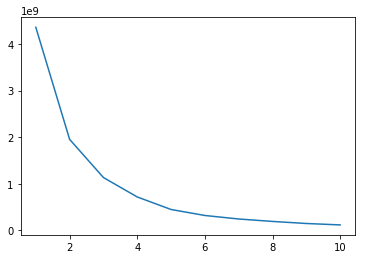

In [648]:
wcss = []
for i in range(1,11):
    
    kmeans=KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init=10)
    kmeans.fit(df)
    
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss)
plt.show()

As we can see there was a big jump 1-2 untill 4. From 6, the WCSS has decreased with very little margin. So, let's set our K=6 for now and see if the results make any sense

# Clustering Results

Not much difference was observed for clusters ranging from 5-7

In [962]:
kmeans=KMeans(n_clusters = 5, init = 'k-means++', max_iter = 300, n_init=10)
y_kmeans=kmeans.fit_predict(df)

A plot of 5 clusters between Month & local_amount (Total amount) for a Sunday

Text(0,0.5,'Total amount')

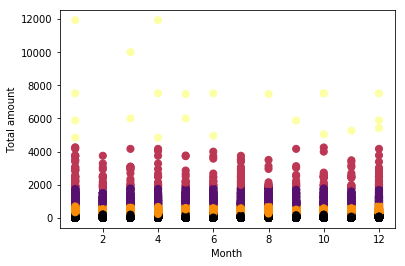

A plot of 5 clusters between Month & local_amount (Total amount) for a Saturday

Text(0,0.5,'Total amount')

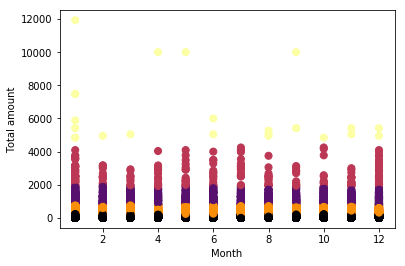

A plot of 5 clusters between Month & local_amount (Total amount) for a Friday

Text(0,0.5,'Total amount')

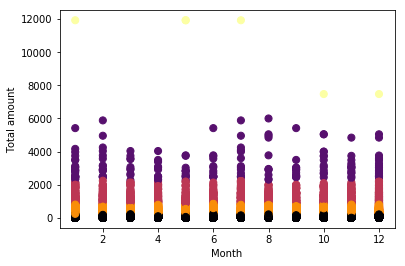

A plot of 5 clusters between Month & local_amount (Total amount) for a Thursday

Text(0,0.5,'Total amount')

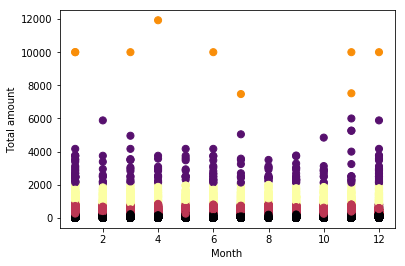

A plot of 5 clusters between Month & local_amount (Total amount) for a Wednesday

Text(0,0.5,'Total amount')

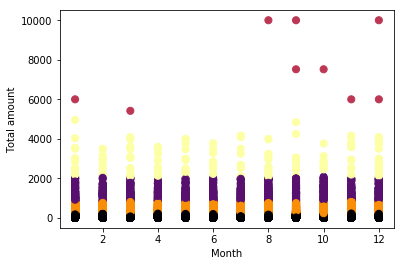

A plot of 5 clusters between Month & local_amount (Total amount) for a Tuesday

Text(0,0.5,'Total amount')

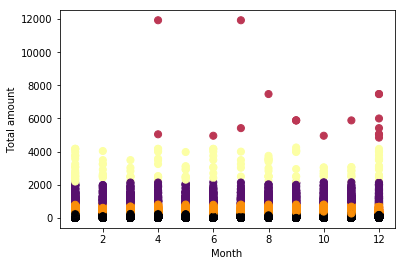

A plot of 5 clusters between Month & local_amount (Total amount) for a Monday

Text(0,0.5,'Total amount')

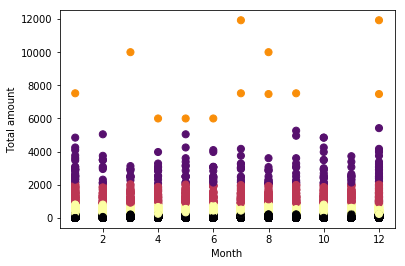

# Clustering results with Merchants

For the days: Friday, Satuday, Sunday & Monday, we have 5 clusters. 

Each of these clusters shows a lineplot depicting %age of transactions for top 5 merchants for that day and in that cluster number

Lastly, a bar plot shows the relationship between each cluster and average amount spent in it

In [ ]:
df['Cluster']=y_kmeans

cluster_index=[]
cluster_amounts=[]

for x in range(0,df['Cluster'].nunique()):
    cluster_df=df[df['Cluster']==x].describe()
    valid_columns=[]

    for i in range(cluster_df.shape[1]):

        if i==cluster_df.shape[1]:
            break

        if cluster_df[cluster_df.columns[i]]['max'] > 0:
            valid_columns.append(cluster_df.columns[i])

    cluster_df=cluster_df[valid_columns]

    print('\n\nCluster: ',x)
    
    try:
        cluster_df_analysis=cluster_df.drop(['month','year','day','Cluster'], axis=1).T.sort_values('mean', ascending=False)
        start=2
    except:
        start=3

    cluster_amounts.append(np.round(cluster_df_analysis.iloc[0]['mean'],2))
    cluster_index.append(x)
    
    print("\nNo. of Transactions with Merchants (Top 5):")
    
    cluster_merchant_name=[]
    cluster_merchant_share=[]
    
    for i in range(start,7):
        cluster_merchant_name.append(cluster_df_analysis.index[i].split('merchant_')[1])
        cluster_merchant_share.append(np.round(cluster_df_analysis.iloc[i]['mean']*100,2))
        
    sns.lineplot(cluster_merchant_name, cluster_merchant_share)
    plt.xlabel('Merchant')
    plt.ylabel('No. of Transaction (%)')
    plt.xticks(rotation=45)
    plt.show()
        
sns.barplot(cluster_index, cluster_amounts)
plt.xlabel('Cluster No. for Day')
plt.ylabel('Total Amount Spent')



Cluster:  0

No. of Transactions with Merchants (Top 5):


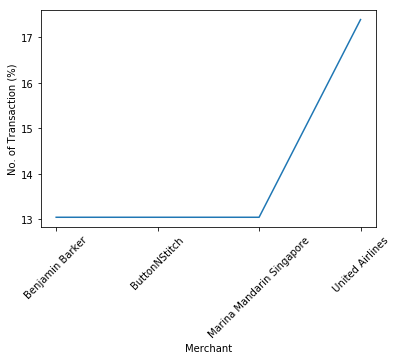



Cluster:  1

No. of Transactions with Merchants (Top 5):


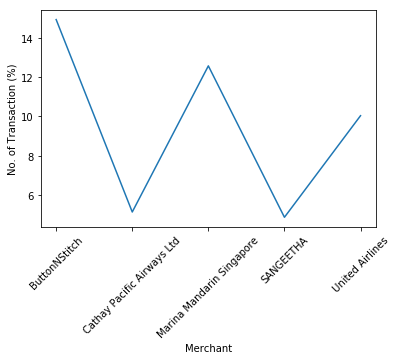



Cluster:  2

No. of Transactions with Merchants (Top 5):


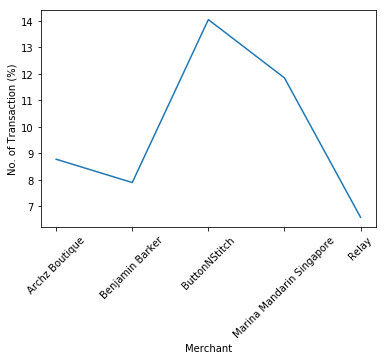



Cluster:  3

No. of Transactions with Merchants (Top 5):


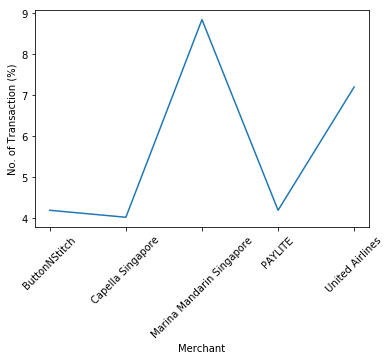



Cluster:  4

No. of Transactions with Merchants (Top 5):


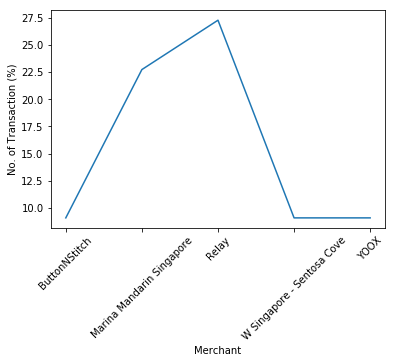

Text(0,0.5,'Total Amount Spent')

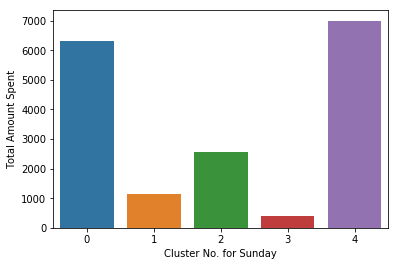

In [843]:
# Sunday



Cluster:  0

No. of Transactions with Merchants (Top 5):


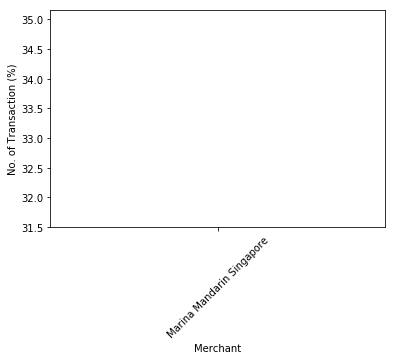



Cluster:  1

No. of Transactions with Merchants (Top 5):


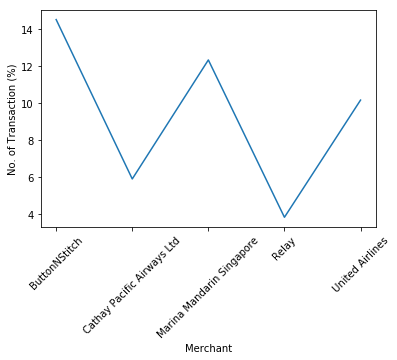



Cluster:  2

No. of Transactions with Merchants (Top 5):


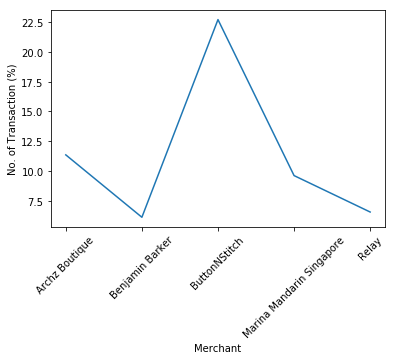



Cluster:  3

No. of Transactions with Merchants (Top 5):


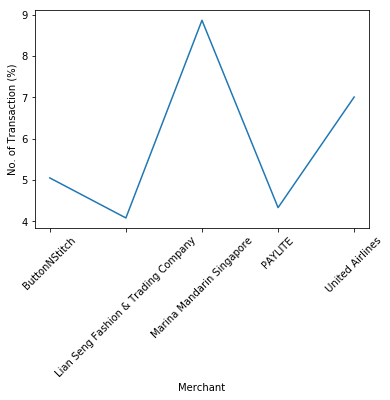



Cluster:  4

No. of Transactions with Merchants (Top 5):


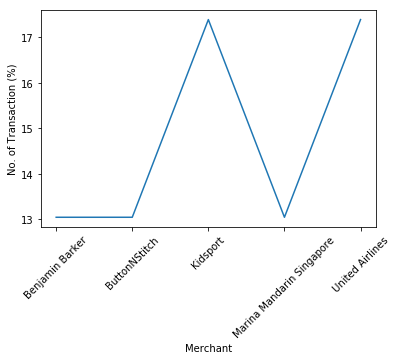

Text(0,0.5,'Total Amount Spent')

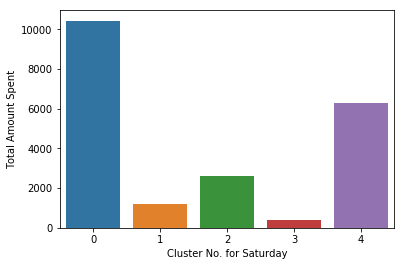

In [837]:
# Saturday



Cluster:  0

No. of Transactions with Merchants (Top 5):


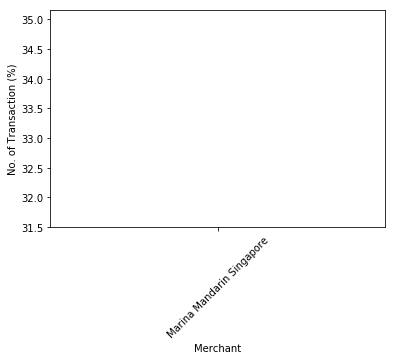



Cluster:  1

No. of Transactions with Merchants (Top 5):


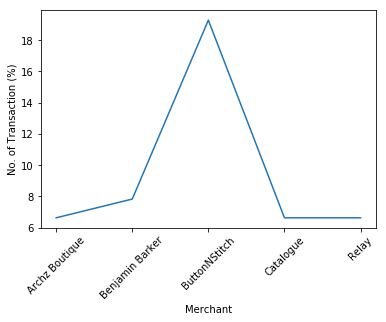



Cluster:  2

No. of Transactions with Merchants (Top 5):


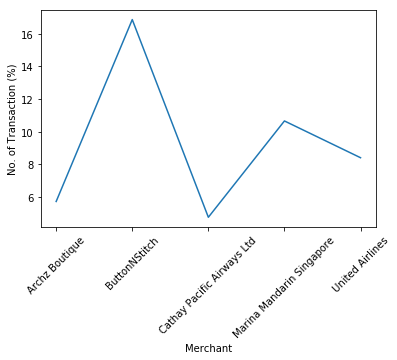



Cluster:  3

No. of Transactions with Merchants (Top 5):


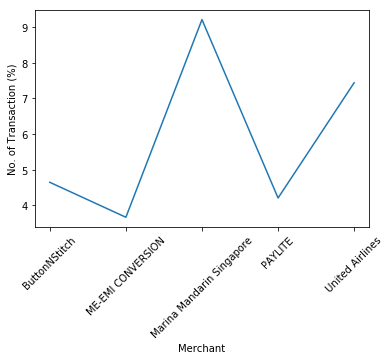



Cluster:  4

No. of Transactions with Merchants (Top 5):


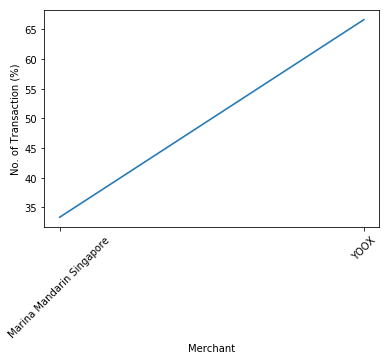

Text(0,0.5,'Total Amount Spent')

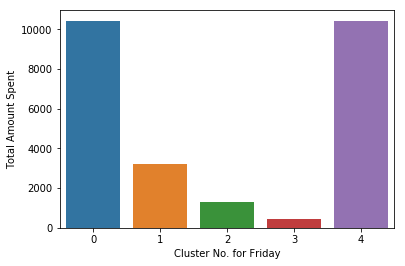

In [831]:
# Friday



Cluster:  0

No. of Transactions with Merchants (Top 5):


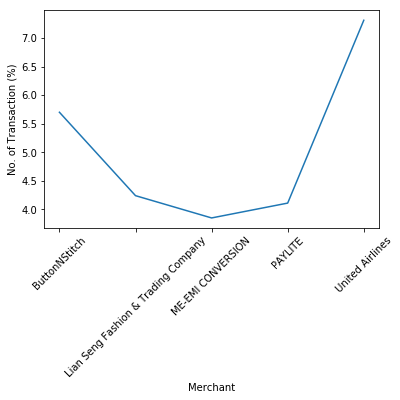



Cluster:  1

No. of Transactions with Merchants (Top 5):


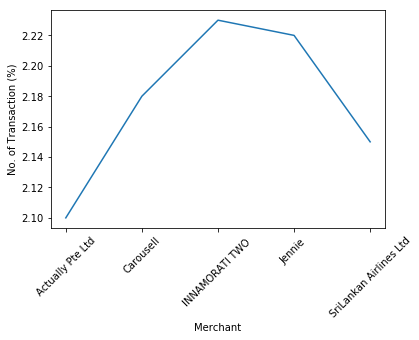



Cluster:  2

No. of Transactions with Merchants (Top 5):


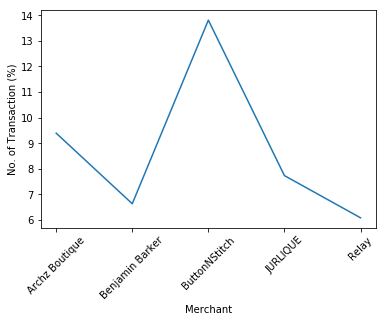



Cluster:  3

No. of Transactions with Merchants (Top 5):


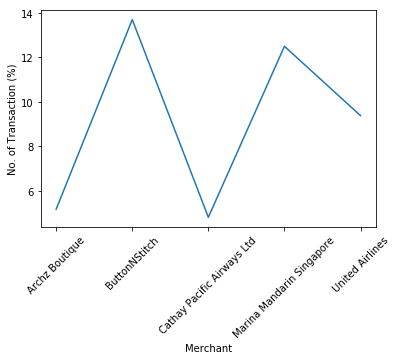



Cluster:  4

No. of Transactions with Merchants (Top 5):


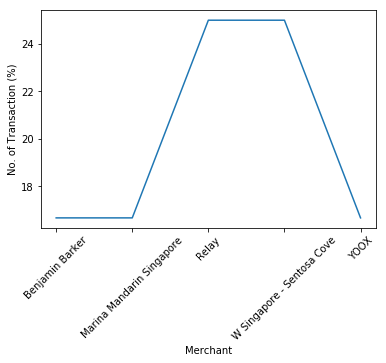

Text(0,0.5,'Total Amount Spent')

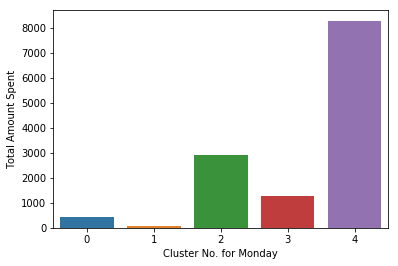

In [774]:
# Monday

# Apriori: Association Rules: Analyzing "Frequent" behavior

Association Rules is a rule learning algorithm, in simpler terms helps finds frequent transactions that occur in a dataset.

Generally, Apriori develops rules based on 3 important factor:
    1. Support: How often does a set of items appear in the data
    
    2. Confidence: How often is the rule correct, ranging from 0 to 1, a rule, say conf(A -> B) having a confidence of 0.7 would mean that if A is pruchased then B will also be purchased 70% of the times or this rule is correct 70% of the times
    
    3. Lift: This metric tells us how significant is the rule. If the Lift is 1, that'd mean there's no relationship between the rules and it may have happened on a random occurence, while Lift > 1 would mean a positive relationship i.e. rule didn't happen by chance is significant
        
We'll try to find any frequent items in our dataset. Using this algorithm we'd be able to answer the following types of questions:
    
    1. If people transact with "United Airlines" do they also transact with "Airtel"?
    
    2. If people transact on Friday do they also transact on Saturday?

# Basic Cleaning/Re-Import

In [970]:
df=pd.read_csv('data.csv')
df.drop(['cleaned_merchant_name.1','country','finalmerchid','MCC'], axis=1, inplace=True)
merchant_count=pd.DataFrame(df.groupby(['cleaned_merchant_name']).count())

merchant_count=merchant_count.sort_values('customerId', ascending=False)
merchant_count.drop(['local_amount','city','txn_date'], axis=1, inplace=True)
merchant_count.reset_index(inplace=True)
merchant_count.columns=['cleaned_merchant_name','count']

merchant_count=merchant_count[merchant_count['count']>=800]
merchant_count['keep']=1

df=pd.merge(df, merchant_count, on='cleaned_merchant_name')
df=df[df['keep']==1]

df.drop(['count','keep'], axis=1, inplace=True)
df.columns=['customerId', 'local_amount', 'merchant', 'city', 'txn_date']
df.head()

,customerId,local_amount,merchant,city,txn_date
0,B01A08255D,24,Restaurant Absinthe,Singapore,18/1/2016
1,B01A00107D,65,Restaurant Absinthe,Singapore,28/1/2016
2,B01A01678D,8,Restaurant Absinthe,Singapore,21/1/2016
3,B01A00610D,12,Restaurant Absinthe,Singapore,5/1/2016
4,B01A06536D,28,Restaurant Absinthe,Singapore,1/1/2016


Split "txn_date" into date, month, day of week, year and convert to their respective names

In [971]:
df['weekday']=df['txn_date'].apply(get_day_of_week)
df['month']=df['txn_date'].apply(get_month)
df['year']=df['txn_date'].apply(get_year)
df['day']=df['txn_date'].apply(get_day)

df.drop(['local_amount','txn_date'], axis=1, inplace=True)

df['weekday']=df['weekday'].apply(lambda x:list(calendar.day_name)[x])
df['month']=df['month'].apply(lambda x:list(calendar.month_name)[x])

df['year']=df['year'].apply(lambda x:str(x))

Overview of Data

In [972]:
df.head()

,customerId,merchant,city,weekday,month,year,day
0,B01A08255D,Restaurant Absinthe,Singapore,Monday,January,2016,18
1,B01A00107D,Restaurant Absinthe,Singapore,Thursday,January,2016,28
2,B01A01678D,Restaurant Absinthe,Singapore,Thursday,January,2016,21
3,B01A00610D,Restaurant Absinthe,Singapore,Tuesday,January,2016,5
4,B01A06536D,Restaurant Absinthe,Singapore,Friday,January,2016,1


In [975]:
df_preserve=df

In [976]:
df_preserve.shape

(350629, 7)

Next section of code was modified several times to generate the different kinds of outputs. Please uncomment any of the following 3 lines.

Using dummy variables, we'll re-structure our data at Merchant & Weekday level. Next, we'll group all transactions by "Customer", this will shape our data into a "Market Basket Problem" data

In [977]:
# Uncomment any of these
# df_1=pd.get_dummies(df_preserve[['weekday']])
df_1=pd.get_dummies(df_preserve[['merchant','weekday']])
# df_1=pd.get_dummies(df_preserve[['merchant']])

df_preserve.drop(['merchant','city','weekday','month','day','year','weekday','month'], inplace=True, axis=1)
df_preserve=pd.concat([df_preserve,df_1], axis=1)

df_preserve=df_preserve.groupby(['customerId'])[list(df_preserve.columns)[1:]].sum().reset_index()
df_preserve.drop(['customerId'], axis=1, inplace=True)

Convert all numbers to 1 as we just want to know that a transaction was made or not

In [979]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

df_preserve = df_preserve.applymap(encode_units)

Overview of Data

In [980]:
df_preserve.head()

,merchant_A B Piyasena Jewellers,merchant_A Better Florist,merchant_AIRCEL,merchant_AIRTEL,merchant_Actually Pte Ltd,merchant_Alain Figaret (Singapore) Pte Ltd,merchant_Alef Motif,merchant_AliExpress,merchant_Alibaba,merchant_All Nippon Airways Co Ltd,merchant_American Airlines,merchant_Amore-Venti,merchant_Archz Boutique,merchant_BALANCE CONVERSION - 001/006,merchant_BALANCE CONVERSION - 003/006,merchant_BALANCE CONVERSION - 005/006,merchant_BALANCE CONVERSION - 006/006,merchant_BANGALORE ELECTRICITY,merchant_BESCOM PAYMENT,merchant_BHARATI TELEMEDIA,merchant_BHARTI CELLULAR,merchant_BHARTI INFOTEL,merchant_BeautyFresh,merchant_Bee Hoe Fashions,merchant_Benjamin Barker,merchant_Billet-Doux,merchant_Bistecca Tuscan Steakhouse,merchant_Bods & Leggs,merchant_ButtonNStitch,merchant_Cafebond,merchant_Capella Singapore,merchant_Carousell,merchant_Catalogue,merchant_Cathay Pacific Airways Ltd,merchant_Chia Huay Cheok,merchant_China Airlines Ltd,merchant_Chock Full of Beans,merchant_Cilla Creative Pursuit,merchant_Club 21,merchant_Club21,merchant_Cocomi Online Store,merchant_D2H,merchant_DAIL-AN-EMI,merchant_Denizen,merchant_Eleonora Bonucci,merchant_F-B Fashion & Beauty,merchant_FREECHARGE PU,merchant_FREECHARGE.IN-PAYU,merchant_FarEastFlora,merchant_Feng Shui Inn,merchant_Get Set Go,merchant_HBX,merchant_Hai Tien Lo,merchant_Happyfresh,merchant_Helpling,merchant_Her Velvet Vase,merchant_Hombre Cantina,merchant_Honestbee,merchant_IDEA,merchant_IKYU,merchant_INNAMORATI TWO,merchant_JURLIQUE,merchant_Jade,merchant_Jennie,merchant_Keyaki,merchant_Kidsport,merchant_Kidzloft,merchant_Kuvo,merchant_Kwang Sia Fashion Company,merchant_Kwang Sia Pte Ltd,merchant_La-Vie Fashion & Bridal,merchant_Lashino Trading,merchant_Lazada,merchant_Lemon Dot Fashion Pte Ltd,merchant_Levi�s,merchant_Lian Qi Fashion,merchant_Lian Seng Fashion & Trading Company,merchant_Lips Enterprise,merchant_Lisa Penny Fashion Design,merchant_Luxola,merchant_ME-EMI CONVERSION,merchant_ME-EMI CONVERSION - 006/006,merchant_Malaysia Airlines,merchant_Marina Mandarin Singapore,merchant_Megafash,merchant_Meilina Boutique,merchant_Mesh Designs,merchant_Meto Tailor,merchant_Moonriver,merchant_Museo,merchant_Nail Palace,merchant_Needle Boutique,merchant_New Future Boutique,merchant_Nike,merchant_Not Just a Label,merchant_ONLINE RECHARGE SERVICES,merchant_Ogawa Healthcare,merchant_Ohvola,merchant_PAYLITE,merchant_PPP Laser Clinic,merchant_Perfumestore,merchant_Petit Bateau,merchant_Prive Cafe,merchant_Prive Grill,merchant_Q & M Dental Group,merchant_Q0010,merchant_REL RETAIL -FRESH,merchant_RELIANCEINFO,merchant_Raffles Grill,merchant_Rakuten,merchant_Redmart,merchant_Reebonz,merchant_Relay,merchant_Restaurant Absinthe,merchant_Restaurant Labyrinth,merchant_Richmond Station,merchant_Roomorama,merchant_Rosebullet,merchant_S Club Fashion,merchant_SANGEETHA,merchant_SGSHOP,merchant_STRIP,merchant_Shinzo Japanese Cuisine,merchant_ShopLah,merchant_Simmons,merchant_Singsale,merchant_SriLankan Airlines Ltd,merchant_Starwood Hotels & Resorts,merchant_T.M. Lewin,merchant_TATA INDICOM,merchant_TATA INDICOM-DOCOMO,merchant_TATA SKY COM,merchant_Taobao,merchant_The Travel Store,merchant_Times Travel,merchant_Turkish Airlines,merchant_United Airlines,merchant_VISA BILLPAY-VODAFONE,merchant_VISABILLPAY-BESCOM,merchant_W Singapore - Sentosa Cove,merchant_World of Watches 2,merchant_YOOX,merchant_Young Living Essential Oils,merchant_Zafferano,merchant_Zalora,merchant_ZenMarket,merchant_anySiS,merchant_honestbee,merchant_iCB,merchant_iMyBags,merchant_www.paytm.com,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1
1,0,0,0,1,

In [442]:
frequent_itemsets = apriori(df_preserve, min_support=0.1, use_colnames=True)

In [444]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Apriori Results

Following is pattern that emerged from transactions with the Merchant "United Airlines"
Suprisingly, no such pattern was observed for Sri Lankan or Malaysian Arilines

As you can see, there's some kind of relationship in transactions that occur on Tuesday & Wednesday => also occur on Saturday and vice versa. Although, the confidence is just 35% we cannot label these insights as actionable

In [329]:
rules.sort_values(['confidence'], ascending=False).head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1,(weekday_Tuesday),(weekday_Saturday),0.351899,0.374684,0.133333,0.378897,1.011245,0.001483,1.006784
2,(weekday_Wednesday),(weekday_Saturday),0.358650,0.374684,0.135021,0.376471,1.004769,0.000641,1.002866
3,(weekday_Saturday),(weekday_Wednesday),0.374684,0.358650,0.135021,0.360360,1.004769,0.000641,1.002674
0,(weekday_Saturday),(weekday_Tuesday),0.374684,0.351899,0.133333,0.355856,1.011245,0.001483,1.006143


Following is the relationship table for Rules by Weekday

General Conclusion:
1. People that transact on a Friday, transact every day except Monday
2. There's a high relationship between Friday & Saturday, with a confidence of 65%. We can use these insights to create special offers for people who transact on friday and encourage them to transact more on following days
3. People transacting on weekends transact on Friday/Tuesday

In [259]:
rules.sort_values(['support'], ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2890,(weekday_Saturday),(weekday_Friday),0.613980,0.613851,0.402918,0.656240,1.069055,0.026026,1.123310
2891,(weekday_Friday),(weekday_Saturday),0.613851,0.613980,0.402918,0.656378,1.069055,0.026026,1.123386
2898,(weekday_Wednesday),(weekday_Friday),0.608635,0.613851,0.400935,0.658746,1.073136,0.027324,1.131558
2899,(weekday_Friday),(weekday_Wednesday),0.613851,0.608635,0.400935,0.653148,1.073136,0.027324,1.128335
2914,(weekday_Saturday),(weekday_Tuesday),0.613980,0.611027,0.400720,0.652659,1.068134,0.025561,1.119859
2915,(weekday_Tuesday),(weekday_Saturday),0.611027,0.613980,0.400720,0.655813,1.068134,0.025561,1.121542
2894,(weekday_Friday),(weekday_Thursday),0.613851,0.610661,0.400526,0.652481,1.068483,0.025671,1.120338
2895,(weekday_Thursday),(weekday_Friday),0.610661,0.613851,0.400526,0.655889,1.068483,0.025671,1.122165
2892,(weekday_Friday),(weekday_Sunday),0.613851,0.608204,0.400397,0.652270,1.072453,0.027050,1.126726
2893,(weekday_Sunday),(weekday_Friday),0.608204,0.613851,0.400397,0.658327,1.072453,0.027050,1.130170


Another analysis was done by keeping both "Merchant" and "Weekday" into consideration. The "support" in this case starts at 0.01% meaning 450 records approx.

General Conclusions:
1. People who transact on friday and transact with merchants PAYLITE + Raffles Grill will make a transaction on Tuesday
2. Similarly, People transaction with merchants Marina Mandarin Singapore + Club 21 and transact on thursday will also transact on Friday

With confidence of 1, meaning the rule being correct 100% of the times and lift > 1, these insights can be labelled as actionable

In [245]:
rules.sort_values(['confidence'], ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
713201,"(merchant_Club 21, merchant_Marina Mandarin Singapore, weekday_Wednesday, weekday_Tuesday, weekday_Thursday)",(weekday_Friday),0.001013,0.613851,0.001013,1.000000,1.629060,0.000391,inf
469286,"(merchant_PAYLITE, weekday_Wednesday, weekday_Friday, merchant_Raffles Grill)",(weekday_Tuesday),0.001013,0.611027,0.001013,1.000000,1.636588,0.000394,inf
469257,"(merchant_PAYLITE, weekday_Friday, merchant_Raffles Grill, weekday_Thursday)",(weekday_Tuesday),0.001035,0.611027,0.001035,1.000000,1.636588,0.000402,inf
469226,"(merchant_PAYLITE, weekday_Friday, weekday_Sunday, merchant_Raffles Grill)",(weekday_Tuesday),0.001013,0.611027,0.001013,1.000000,1.636588,0.000394,inf
913107,"(weekday_Sunday, weekday_Saturday, merchant_TATA INDICOM-DOCOMO, merchant_Raffles Grill, weekday_Tuesday)",(weekday_Friday),0.001013,0.613851,0.001013,1.000000,1.629060,0.000391,inf
157803,"(weekday_Friday, merchant_PAYLITE, merchant_Raffles Grill)",(weekday_Tuesday),0.001078,0.611027,0.001078,1.000000,1.636588,0.000419,inf
329404,"(weekday_Wednesday, weekday_Thursday, merchant_Club 21, merchant_Marina Mandarin Singapore)",(weekday_Friday),0.001099,0.613851,0.001099,1.000000,1.629060,0.000424,inf
95762,"(merchant_Marina Mandarin Singapore, merchant_Club 21, weekday_Thursday)",(weekday_Friday),0.001444,0.613851,0.001423,0.985075,1.604746,0.000536,25.871988
329374,"(weekday_Thursday, weekday_Tuesday, merchant_Club 21, merchant_Marina Mandarin Singapore)",(weekday_Friday),0.001229,0.613851,0.001207,0.982456,1.600480,0.000453,22.010497
329194,"(weekday_Saturday, weekday_Thursday, merchant_Club 21, merchant_Marina Mandarin Singapore)",(weekday_Friday),0.001207,0.613851,0.001185,0.982143,1.599970,0.000445,21.624348


Finally, this is the analysis between "Merchants" only. With very high lifts and confidence at less than 50% we could explore some of these rules using external data souces

General conclusions:
1. When transactions with Bhart Cellular + Malaysian Airlines occur, transactions with FarEastFlora also take place
2. There is some relation between Malaysian Airlines and FarEastFlora as it is listed multiple times
3. People transacting with Jurlique also transact with Nail Palace (low confidence, high lift)

In [197]:
rules.sort_values(['confidence'], ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
783,"(merchant_BHARTI CELLULAR, merchant_Malaysia Airlines)",(merchant_FarEastFlora),0.002802,0.035565,0.001164,0.415385,11.679608,0.001064,1.649692
782,"(merchant_BHARTI CELLULAR, merchant_FarEastFlora)",(merchant_Malaysia Airlines),0.003729,0.026620,0.001164,0.312139,11.725801,0.001065,1.415082
501,(merchant_Malaysia Airlines),(merchant_FarEastFlora),0.026620,0.035565,0.007113,0.267206,7.513198,0.006166,1.316108
494,(merchant_FREECHARGE.IN-PAYU),(merchant_FREECHARGE PU),0.007652,0.008406,0.001940,0.253521,30.158613,0.001876,1.328361
245,(merchant_BHARTI INFOTEL),(merchant_BHARTI CELLULAR),0.028775,0.076993,0.006941,0.241199,3.132744,0.004725,1.216402
621,(merchant_Nail Palace),(merchant_JURLIQUE),0.007005,0.007221,0.001617,0.230769,31.959127,0.001566,1.290613
495,(merchant_FREECHARGE PU),(merchant_FREECHARGE.IN-PAYU),0.008406,0.007652,0.001940,0.230769,30.158613,0.001876,1.290053
620,(merchant_JURLIQUE),(merchant_Nail Palace),0.007221,0.007005,0.001617,0.223881,31.959127,0.001566,1.279436
500,(merchant_FarEastFlora),(merchant_Malaysia Airlines),0.035565,0.026620,0.007113,0.200000,7.513198,0.006166,1.216725
449,(merchant_FREECHARGE PU),(merchant_Eleonora Bonucci),0.008406,0.072682,0.001509,0.179487,2.469492,0.000898,1.130169


END